# Análisis comparativo de robustez entre Momentos de Hu y Zernike

## Preprocesamiento y Aumento de Datos:

### Importar librerías necesarias

In [41]:
import math
import mahotas
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

### Cargar imágenes de muestra desde las carpetas de datos

In [5]:
# Configuración de rutas
DATASET_PATH = "../data/all-images/" 
CLASSES = ["circle", "triangle", "square"]

In [13]:
def load_sample_images(base_path, categories):
    samples = []
    
    for category in categories:
        path = os.path.join(base_path, category)
        if not os.path.exists(path):
            print(f"ruta no válida: {path}")
            continue
            
        # listar los archivos y tomar el primero
        files = os.listdir(path)
        for file in files:
            if file.endswith(('.PNG', '.JPG', '.JPEG')):
                img_path = os.path.join(path, file)
                # escala de grises (modo 0)
                img = cv2.imread(img_path, 0) 
                samples.append((category, img))
                break
    return samples

In [11]:
# Cargar muestras
sample_images = load_sample_images(DATASET_PATH, CLASSES)

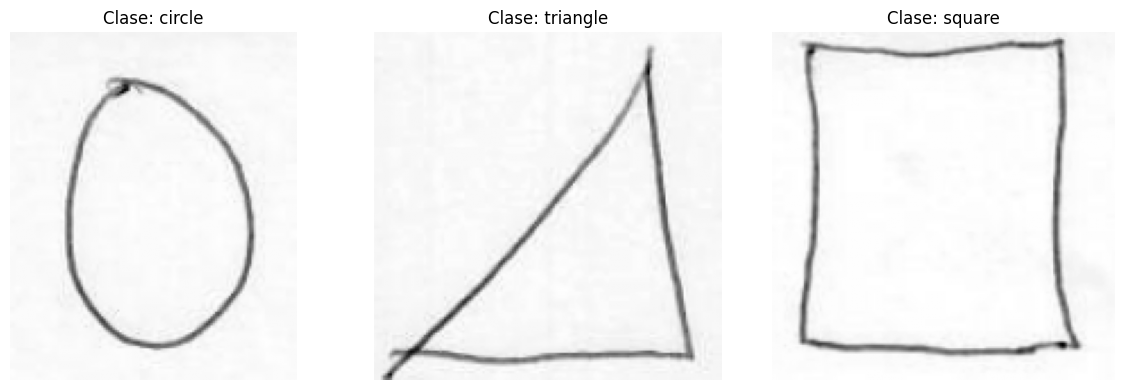

In [14]:
# Visualizar
plt.figure(figsize=(12, 4))
for i, (name, img) in enumerate(sample_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Clase: {name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Funsión de ruido

- Agregar ruido gaussiano

In [23]:
def add_gaussian_noise(image, level='bajo'):
    # Agrega ruido Gaussiano a una imagen y los niveles controlan la desviación estándar

    row, col = image.shape
    mean = 0
    
    levels = {
        'bajo': 10,   
        'medio': 40,   
        'alto': 80     
    }
    
    sigma = levels.get(level, 10)
    
    # Generar ruido gaussiano
    gauss = np.random.normal(mean, sigma, (row, col))
    
    # Sumar ruido a la imagen
    noisy_image = image.astype(np.float32) + gauss
    
    # Normalizar para mantener valores entre 0 y 255 y convertir a uint8
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

- Agregar ruido gaussiano

In [24]:
def add_salt_pepper_noise(image, level='bajo'):
    # Agrega ruido tipo Sal y Pimienta y los niveles controlan la probabilidad de afectación
    row, col = image.shape
    noisy_image = np.copy(image)
    
    # Definir probabilidad (cantidad de ruido)
    levels = {
        'bajo': 0.02,   # 2% de los píxeles afectados
        'medio': 0.10,  # ...
        'alto': 0.25    
    }
    
    prob = levels.get(level, 0.02)
    
    # pixeles blancos
    # generar máscara aleatoria
    num_salt = np.ceil(prob * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[tuple(coords)] = 255

    # pixeles negros
    num_pepper = np.ceil(prob * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[tuple(coords)] = 0
    
    return noisy_image

- Prueba de funciones de ruido

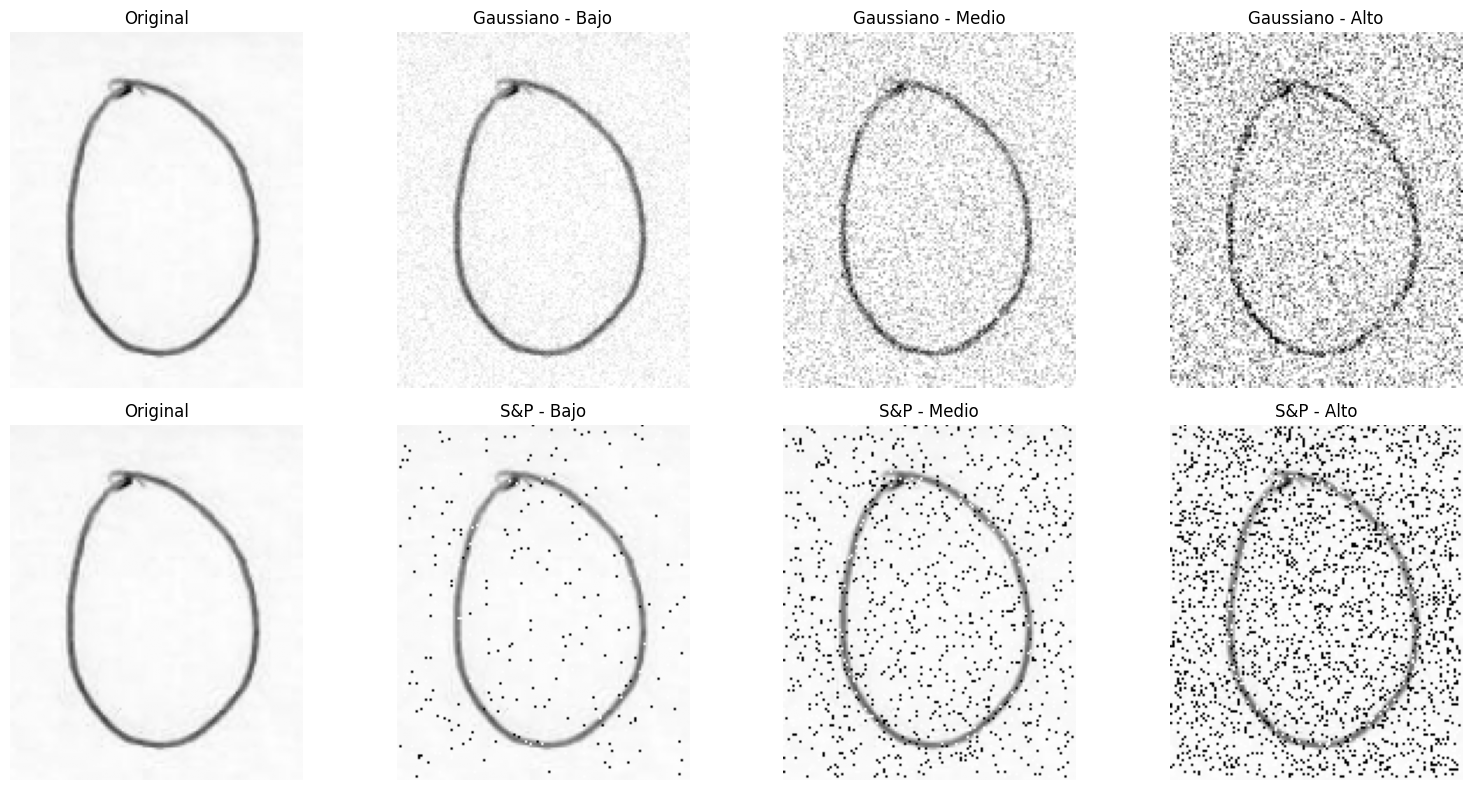

In [19]:
if len(sample_images) > 0:
    # usar primera imagen cargada
    test_img_name, test_img = sample_images[0] 
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Fila 1: Ruido Gaussiano
    axes[0,0].imshow(test_img, cmap='gray')
    axes[0,0].set_title("Original")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(add_gaussian_noise(test_img, 'bajo'), cmap='gray')
    axes[0,1].set_title("Gaussiano - Bajo")
    axes[0,1].axis('off')
    
    axes[0,2].imshow(add_gaussian_noise(test_img, 'medio'), cmap='gray')
    axes[0,2].set_title("Gaussiano - Medio")
    axes[0,2].axis('off')
    
    axes[0,3].imshow(add_gaussian_noise(test_img, 'alto'), cmap='gray')
    axes[0,3].set_title("Gaussiano - Alto")
    axes[0,3].axis('off')

    # Fila 2: Ruido Sal y Pimienta
    axes[1,0].imshow(test_img, cmap='gray')
    axes[1,0].set_title("Original")
    axes[1,0].axis('off')
    
    axes[1,1].imshow(add_salt_pepper_noise(test_img, 'bajo'), cmap='gray')
    axes[1,1].set_title("S&P - Bajo")
    axes[1,1].axis('off')
    
    axes[1,2].imshow(add_salt_pepper_noise(test_img, 'medio'), cmap='gray')
    axes[1,2].set_title("S&P - Medio")
    axes[1,2].axis('off')
    
    axes[1,3].imshow(add_salt_pepper_noise(test_img, 'alto'), cmap='gray')
    axes[1,3].set_title("S&P - Alto")
    axes[1,3].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes en sample_images. Revisa el paso anterior.")

### Generar variantes con rotaciones aleatorias

In [20]:
def rotate_image_randomly(image):
    # rota la imagen un ángulo aleatorio entre 0 y 360 grados
    # rellena el fondo con el color predominante de la imagen 

    # ángulo aleatorio
    angle = random.uniform(0, 360)
    
    # obtener dimensiones y centro
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # matriz de rotación
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # detectar color de fondo (tomamos el píxel de la esquina superior izquierda)
    # esto es útil si tus imágenes son dibujos en papel (fondo blanco/gris)
    bg_color = int(image[0, 0])
    
    # aplicar la rotación
    # borderValue usa el color detectado para rellenar lo que queda vacío al girar
    rotated = cv2.warpAffine(image, M, (w, h), borderValue=bg_color)
    
    return rotated, angle

- Pruebas de rotación aleatoria

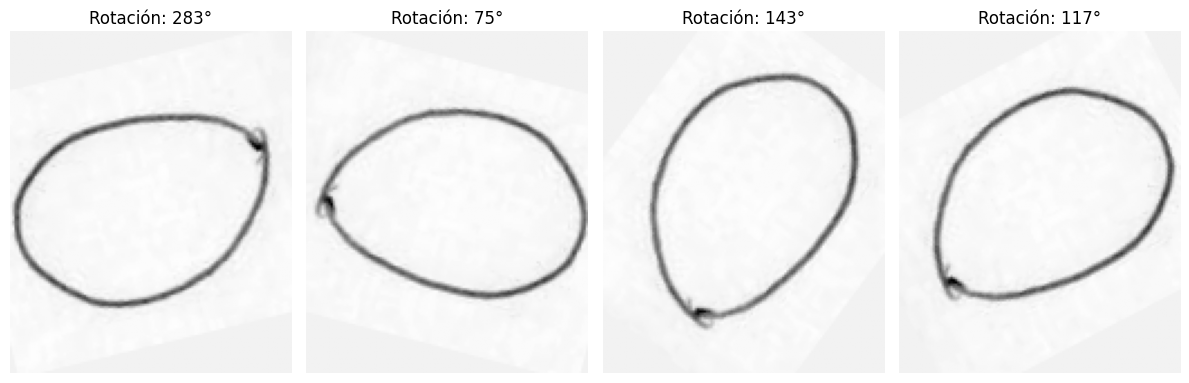

In [21]:
if len(sample_images) > 0:
    test_img_name, test_img = sample_images[0] 
    
    plt.figure(figsize=(12, 4))

    for i in range(4):
        rotated_img, angle_used = rotate_image_randomly(test_img)
        
        plt.subplot(1, 4, i+1)
        plt.imshow(rotated_img, cmap='gray')
        plt.title(f"Rotación: {int(angle_used)}°")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No hay imágenes cargadas para probar.")

## Extracción de características

### Hu Moments

In [44]:
def extract_hu_moments(image):
    # Calcula los 7 Momentos de Hu.
    # limpiar ruido con filtro de mediana antes de binarizar
    denoised = cv2.medianBlur(image, 5)
    
    # preprocesamiento: Invertir y Binarizar (Usando la imagen limpia)
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # calcular Momentos
    moments = cv2.moments(binary)
    hu_moments = cv2.HuMoments(moments)
    
    # log Transform
    features = []
    for i in range(7):
        val = hu_moments[i][0]
        if val == 0:
            features.append(0)
        else:
            features.append(-1 * math.copysign(1.0, val) * math.log10(abs(val)))
            
    return features

- Pruebas de momentos de Hu

Figura: circle
Momentos de Hu (Log-transformados):
H1: 2.0776
H2: 5.1756
H3: 8.2123
H4: 8.7967
H5: -17.3733
H6: 11.5430
H7: -17.5760


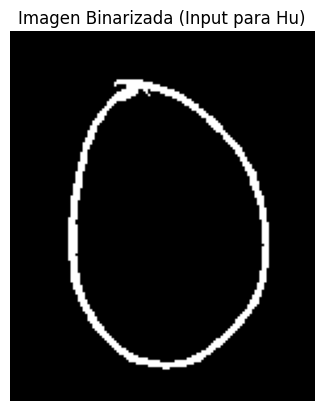

In [45]:
if len(sample_images) > 0:
    name, img = sample_images[0] 
    
    hu_feats = extract_hu_moments(img)
    
    print(f"Figura: {name}")
    print("Momentos de Hu (Log-transformados):")
    for i, val in enumerate(hu_feats):
        print(f"H{i+1}: {val:.4f}")

    # Visualizar lo que "ve" el algoritmo (imagen binarizada)
    _, binary_viz = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.imshow(binary_viz, cmap='gray')
    plt.title("Imagen Binarizada (Input para Hu)")
    plt.axis('off')
    plt.show()

### Zernike Moments

In [46]:
def extract_zernike_moments(image):
    # Calcula Momentos de Zernike (n=8).
    # limpiar ruido con filtro de mediana antes de binarizar
    denoised = cv2.medianBlur(image, 5)
    denoised = cv2.medianBlur(image, 5)
    
    # 1. Binarización
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 2. Bounding Box y Recorte
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.zeros(25)

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    
    pad = 5
    roi = binary[max(0, y-pad):min(binary.shape[0], y+h+pad), 
                 max(0, x-pad):min(binary.shape[1], x+w+pad)]
    
    # 3. Zernike
    radius = max(roi.shape) / 2.0
    zernike = mahotas.features.zernike_moments(roi, radius, degree=8)
    
    return zernike

- Test Zernike Moments

Figura: circle
Cantidad de descriptores Zernike (n=8): 25
Primeros 5 valores: [3.18309886e-01 2.53003818e-16 1.26676803e-01 1.67055331e-01
 8.50586453e-02]


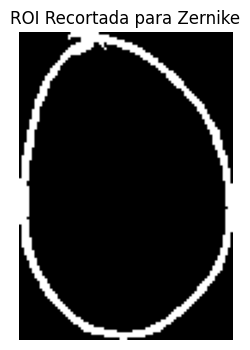

In [47]:
if len(sample_images) > 0:
    name, img = sample_images[0] 
    
    z_feats = extract_zernike_moments(img)
    
    print(f"Figura: {name}")
    print(f"Cantidad de descriptores Zernike (n=8): {len(z_feats)}")
    print(f"Primeros 5 valores: {z_feats[:5]}")
    
    # Visualizar qué parte de la imagen analizó realmente (ROI)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        roi_viz = binary[y:y+h, x:x+w]
        
        plt.figure(figsize=(4,4))
        plt.imshow(roi_viz, cmap='gray')
        plt.title("ROI Recortada para Zernike")
        plt.axis('off')
        plt.show()

## Evaluación de Clasificación

### Entrenar un clasificador simple

In [48]:
CLASSES = ["circle", "triangle", "square"] 
# {'circle': 0, 'triangle': 1, ...}
label_map = {name: i for i, name in enumerate(CLASSES)}

def prepare_training_data(images_list):
    
    # genera el dataset de entrenamiento.
    # entrenar con imágenes LIMPIAS + ROTACIONES.
    # no usamos ruido en el entrenamiento para probar la robustez real del descriptor después.
    
    X_hu = []
    X_zernike = []
    y = []

    print("Preparando datos de entrenamiento...")
    
    for label_name, img in images_list:
        label = label_map[label_name]
        
        # usar imagen original
        # Hu
        X_hu.append(extract_hu_moments(img))
        # Zernike
        X_zernike.append(extract_zernike_moments(img))
        y.append(label)
        
        # generar Data Augmentation 
        # 5 variantes rotadas por cada imagen original para que aprenda invarianza
        for _ in range(5):
            rotated_img, _ = rotate_image_randomly(img)
            
            X_hu.append(extract_hu_moments(rotated_img))
            X_zernike.append(extract_zernike_moments(rotated_img))
            y.append(label)

    return np.array(X_hu), np.array(X_zernike), np.array(y)

In [50]:
# generar features
X_hu, X_zernike, y = prepare_training_data(sample_images)

print(f"\nDatos generados: {len(y)} muestras")
print(f"Dimensiones Hu: {X_hu.shape}")
print(f"Dimensiones Zernike: {X_zernike.shape}")

Preparando datos de entrenamiento...

Datos generados: 18 muestras
Dimensiones Hu: (18, 7)
Dimensiones Zernike: (18, 25)


In [51]:
# dividir en Train/Test (80% / 20%)
# usar el Test set 'limpio' para validar que aprendió y luego generaremos sets de prueba ruidosos aparte.
X_hu_train, X_hu_test, y_train, y_test = train_test_split(X_hu, y, test_size=0.2, random_state=42)
X_zer_train, X_zer_test, _, _ = train_test_split(X_zernike, y, test_size=0.2, random_state=42)

In [52]:
# configurar y Entrenar SVM
# Pipeline que incluye 'StandardScaler'.
svm_hu = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale'))
svm_zernike = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale'))

In [53]:
print("\nEntrenando SVM para Hu Moments...")
svm_hu.fit(X_hu_train, y_train)
acc_hu = svm_hu.score(X_hu_test, y_test)
print(f"Precisión en test limpio (Hu): {acc_hu:.2%}")


Entrenando SVM para Hu Moments...
Precisión en test limpio (Hu): 75.00%


In [54]:
print("Entrenando SVM para Zernike Moments...")
svm_zernike.fit(X_zer_train, y_train)
acc_zer = svm_zernike.score(X_zer_test, y_test)
print(f"Precisión en test limpio (Zernike): {acc_zer:.2%}")

Entrenando SVM para Zernike Moments...
Precisión en test limpio (Zernike): 100.00%


### Generar una Matriz de Confusión para cada nivel de ruido

In [55]:
def stress_test_model(model, descriptor_func, images_list, noise_type, noise_level):
    # prueba el modelo con imágenes ruidosas generadas al vuelo

    X_noise = []
    y_noise = []
    
    for label_name, img in images_list:
        label = label_map[label_name]
        
        # Generar varias pruebas por imagen para tener estadística
        for _ in range(10): 
            # aplicar Ruido
            if noise_type == 'gaussian':
                noisy_img = add_gaussian_noise(img, level=noise_level)
            else:
                noisy_img = add_salt_pepper_noise(img, level=noise_level)
            
            # extraer características
            features = descriptor_func(noisy_img)
            
            X_noise.append(features)
            y_noise.append(label)
            
    # Predecir
    y_pred = model.predict(X_noise)
    return y_noise, y_pred

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(title)
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()

- Pruebas

In [56]:
# configuración de Tests
test_configs = [
    # (Nombre, Modelo Entrenado, Función Extractora)
    ('Hu Moments', svm_hu, extract_hu_moments),
    ('Zernike Moments', svm_zernike, extract_zernike_moments)
]

noise_types = ['gaussian', 's&p']
noise_levels = ['bajo', 'medio', 'alto']

results_log = []

print("Iniciando Tests")

for desc_name, model, func in test_configs:
    for n_type in noise_types:
        for n_level in noise_levels:
            print(f"Testing: {desc_name} | Tipo: {n_type.upper()} | Nivel: {n_level.upper()}...", end=" ")
            
            # Ejecutar el test usando tu función stress_test_model
            y_true, y_pred = stress_test_model(model, func, sample_images, n_type, n_level)
            
            # calcular precisión
            acc = accuracy_score(y_true, y_pred)
            print(f"-> {acc:.2%}")
            
            # guardar para el reporte
            results_log.append({
                'Descriptor': desc_name,
                'Ruido': n_type,
                'Nivel': n_level,
                'Accuracy': acc,
                'y_true': y_true, # guardar las etiquetas para graficar matrices después si queremos
                'y_pred': y_pred
            })

Iniciando Tests
Testing: Hu Moments | Tipo: GAUSSIAN | Nivel: BAJO... -> 100.00%
Testing: Hu Moments | Tipo: GAUSSIAN | Nivel: MEDIO... -> 76.67%
Testing: Hu Moments | Tipo: GAUSSIAN | Nivel: ALTO... -> 33.33%
Testing: Hu Moments | Tipo: S&P | Nivel: BAJO... -> 100.00%
Testing: Hu Moments | Tipo: S&P | Nivel: MEDIO... -> 93.33%
Testing: Hu Moments | Tipo: S&P | Nivel: ALTO... -> 83.33%
Testing: Zernike Moments | Tipo: GAUSSIAN | Nivel: BAJO... -> 100.00%
Testing: Zernike Moments | Tipo: GAUSSIAN | Nivel: MEDIO... -> 100.00%
Testing: Zernike Moments | Tipo: GAUSSIAN | Nivel: ALTO... -> 36.67%
Testing: Zernike Moments | Tipo: S&P | Nivel: BAJO... -> 100.00%
Testing: Zernike Moments | Tipo: S&P | Nivel: MEDIO... -> 100.00%
Testing: Zernike Moments | Tipo: S&P | Nivel: ALTO... -> 86.67%


Resumen Final de Precisión
Nivel                     bajo     medio      alto
Descriptor      Ruido                             
Hu Moments      gaussian   1.0  0.766667  0.333333
                s&p        1.0  0.933333  0.833333
Zernike Moments gaussian   1.0  1.000000  0.366667
                s&p        1.0  1.000000  0.866667
Generando comparativa visual para el caso más difícil (S&P Alto)...


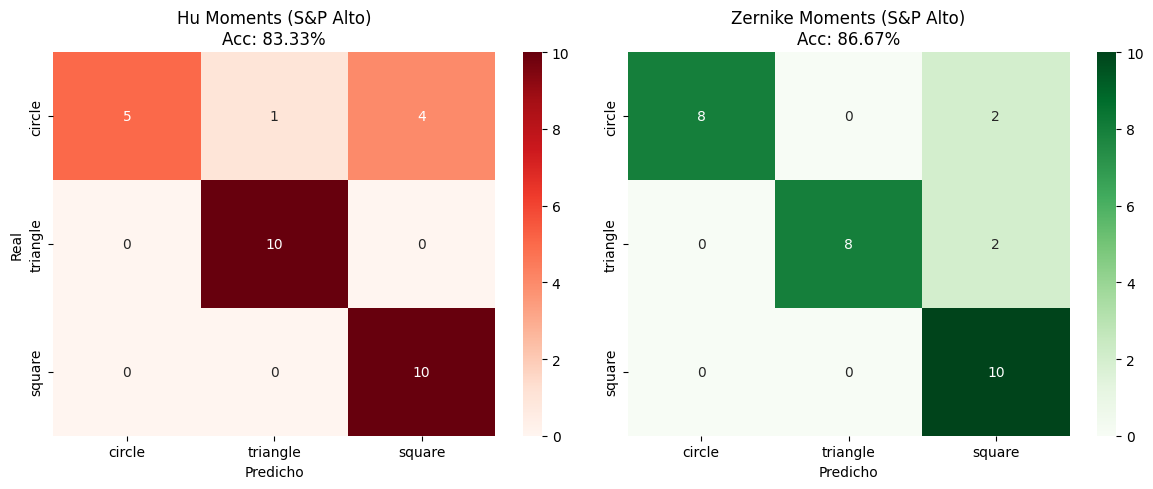

In [57]:
print("Resumen Final de Precisión")

df_results = pd.DataFrame(results_log)

pivot_table = df_results.pivot_table(
    index=['Descriptor', 'Ruido'], 
    columns='Nivel', 
    values='Accuracy'
)

pivot_table = pivot_table[['bajo', 'medio', 'alto']]
print(pivot_table)

# visualización Comparativa: El "Caso Extremo"
# Graficamos las matrices de confusión de ambos descriptores con el ruido más alto (S&P Alto)

print("Generando comparativa visual para el caso más difícil (S&P Alto)...")

# filtrar los resultados para S&P Alto
hu_result = df_results[(df_results['Descriptor'] == 'Hu Moments') & 
                       (df_results['Ruido'] == 's&p') & 
                       (df_results['Nivel'] == 'alto')].iloc[0]

zer_result = df_results[(df_results['Descriptor'] == 'Zernike Moments') & 
                        (df_results['Ruido'] == 's&p') & 
                        (df_results['Nivel'] == 'alto')].iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz Hu
cm_hu = confusion_matrix(hu_result['y_true'], hu_result['y_pred'])
sns.heatmap(cm_hu, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[0].set_title(f"Hu Moments (S&P Alto)\nAcc: {hu_result['Accuracy']:.2%}")
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# Matriz Zernike
cm_zer = confusion_matrix(zer_result['y_true'], zer_result['y_pred'])
sns.heatmap(cm_zer, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[1].set_title(f"Zernike Moments (S&P Alto)\nAcc: {zer_result['Accuracy']:.2%}")
axes[1].set_xlabel('Predicho')

plt.tight_layout()
plt.show()